In [ ]:
library(ggplot2)
library(tidyverse)
library(openxlsx)
library(readxl)
library(asbio)  # partial R squared
library(stringr)
library(reshape)
library(corrplot)
library(RColorBrewer)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: tcltk


Attaching package: 'asbio'


The following object is masked from 'package:lubridate':

    pm



Attaching package: 'reshape'


The following object is masked from 'package:lubridate':

    stamp


The following object is masked from 'package:dplyr':

    rename


The following objects are masked from 'package:tidyr':

    expand, smiths


corrplot 0.95 loaded



In [ ]:
my.color = c('human.chn'="#C1515A",'human.usa'="#4472AD",'human.usa.prolific'='#4472AD',
             'modern'="#C1747A",'ancient'="#F2997A")

# Explore

In [ ]:
# 数据加载和处理
load_and_process_data <- function(evil_file_path, evil_ratings_path, validity) {
  # 读取并清理数据
  evil_df <- read.xlsx(evil_file_path, sheet = 'Evil_features')
  evil_df$'names.of.dimensions' <- trimws(evil_df$'names.of.dimensions')
  evil_eng_map <- setNames(evil_df$'维度名称', evil_df$'names.of.dimensions')
  
  evil_modern_human_chn <- read.csv(evil_ratings_path, row.names = 1, check.names = FALSE)
  
  # 清理列名
  if (!validity){
  colnames(evil_modern_human_chn) <- sub("^(.)", "\\U\\1", colnames(evil_modern_human_chn), perl = TRUE)
  colnames(evil_modern_human_chn) <- colnames(evil_modern_human_chn) %>%
    str_replace("Challenging authority", "Challenge authority") %>%
    str_replace("Disrupting social order", "Disrupt social order")
  
  # 更新列名
  evil_modern_human_chn <- evil_modern_human_chn %>%
    `colnames<-`(evil_eng_map[colnames(.)])}

  # 更新行名
  evil_action = read.xlsx('现代中国人数据最终版/Morality_feature_beh_0427.xlsx',sheet = 'Evil_actions')
  evil_action_map = setNames(evil_action$'Chinese_modified', evil_action$'English_simp')
  evil_modern_human_chn = evil_modern_human_chn %>%
  `rownames<-`(evil_action_map[rownames(.)])
  
  return(evil_modern_human_chn)
}

# 获取矩阵下三角部分
get_lower_triangle <- function(m) {
  return(m[lower.tri(m)])
}

# 数据标准化
scale_data <- function(data) {
  return(scale(data) * sqrt(nrow(data) / (nrow(data) - 1)))
}

# PCA分析和Varimax旋转
perform_pca_and_rotation <- function(data, ncomp = 3) {
  # 主成分分析
  dim_rel.pca <- prcomp(data)
  loadings_none <- dim_rel.pca$rotation[, 1:ncomp] %*% diag(dim_rel.pca$sdev, ncomp, ncomp)
  scores_none <- dim_rel.pca$x[, 1:ncomp]
  
  # Varimax旋转
  loadings_var <- varimax(loadings_none)$loadings
  scores_var <- scale(scores_none) %*% varimax(loadings_none)$rotmat

  loadings_var <- data.frame(loadings_var[,])
  scores_var <- data.frame(scores_var)
  target_vars <- c('不当获利', '危害他人性', '放纵性')
  names_order <- sapply(target_vars, function(x) which.max(abs(loadings_var[x, ])))

  loadings_var = loadings_var[,names_order]
  scores_var = scores_var[,names_order]
  new_names <- c('Unjust.gain', 'Harm.to.others', 'Self.indulgence')
  colnames(loadings_var) <- new_names
  colnames(scores_var) <- new_names

  for (i in seq_along(new_names)) {
    var_name <- target_vars[i]
    col_name <- new_names[i]
    if (loadings_var[var_name, col_name] < 0) {
      loadings_var[, col_name] <- -loadings_var[, col_name]
      scores_var[, col_name] <- -scores_var[, col_name]
    }
  }

  return(list(loadings = loadings_var, scores = scores_var))
}

evil_compute_partial_R2 <- function(model) {
  predictors = colnames(model)[-c(4)]
  results <- list()  
  lm.without <- update(model, ~. -Unjust.gain)
  results[['Unjust.gain']] <- partial.R2(lm.without, model)
  
  lm.without <- update(model, ~. -Harm.to.others)
  results[['Harm.to.others']] <- partial.R2(lm.without, model)    
    
  lm.without <- update(model, ~. -Self.indulgence)
  results[['Self.indulgence']] <- partial.R2(lm.without, model) 
  
  return(results) 
}

In [ ]:
evil_file_path <- '现代中国人数据最终版/Morality_feature_beh_0427.xlsx'
evil_ratings_path_chn <- '现代中国人数据最终版/evil_chn_28dim_100beh_mean_scaled.csv'
evil_modern_human_chn <- load_and_process_data(evil_file_path, evil_ratings_path_chn, FALSE)
evil_modern_human_loadings_chn = perform_pca_and_rotation(evil_modern_human_chn)[['loadings']]
evil_modern_human_scores_chn = perform_pca_and_rotation(evil_modern_human_chn)[['scores']]

evil_modern_human_chn_wrong <- load_and_process_data(evil_file_path, 
                'validity/evil_chn_55dim_100beh_mean_scaled.csv', TRUE)[rownames(evil_modern_human_scores_chn),][['wrongfulness']]
df_chn = cbind(evil_modern_human_scores_chn,evil_modern_human_chn_wrong)
colnames(df_chn)[4] = 'Wrong'
human_modern_chn_model <- lm(data = df_chn , Wrong ~ Unjust.gain + Harm.to.others + Self.indulgence)
partial_r_chn <- evil_compute_partial_R2(human_modern_chn_model)
partial_r_chn

$Unjust.gain
[1] 0.647238

$Harm.to.others
[1] 0.7175888

$Self.indulgence
[1] 0.5604656

In [ ]:
evil_ratings_path_usa <- '现代美国人数据/evil_usa_28dim_100beh_mean_scaled_0710.csv'
evil_modern_human_usa <- load_and_process_data(evil_file_path, evil_ratings_path_usa, FALSE)
evil_modern_human_loadings_usa = perform_pca_and_rotation(evil_modern_human_usa)[['loadings']]
evil_modern_human_scores_usa = perform_pca_and_rotation(evil_modern_human_usa)[['scores']]


evil_modern_human_usa_wrong <- load_and_process_data(evil_file_path, 
                'validity/evil_usa_55dim_100beh_mean_scaled.csv', TRUE)[rownames(evil_modern_human_scores_chn),][['wrongfulness']]
df_usa = cbind(evil_modern_human_scores_usa,evil_modern_human_usa_wrong)
colnames(df_usa)[4] = 'Wrong'
human_modern_usa_model <- lm(data = df_usa , Wrong ~ Unjust.gain + Harm.to.others + Self.indulgence)
partial_r_usa <- evil_compute_partial_R2(human_modern_usa_model)
partial_r_usa

$Unjust.gain
[1] 0.3577403

$Harm.to.others
[1] 0.7990225

$Self.indulgence
[1] 0.1796742

In [ ]:
evil_ancient_llm_chn <- read.csv('../20250708/pic/data/evil_llm_ancient_validity_scaled.csv',row.names = 1)
evil_ancient_llm_loadings_chn = perform_pca_and_rotation(evil_ancient_llm_chn[,-c(27)])[['loadings']]
evil_ancient_llm_scores_chn = perform_pca_and_rotation(evil_ancient_llm_chn[,-c(27)])[['scores']]
evil_ancient_human_chn_Wrong <- evil_ancient_llm_chn[['错误性']]
df_chn_ancient = cbind(evil_ancient_llm_scores_chn,evil_ancient_human_chn_Wrong)
colnames(df_chn_ancient)[4] = 'Wrong'
llm_ancient_chn_model <- lm(data = df_chn_ancient , Wrong ~ Unjust.gain + Harm.to.others + Self.indulgence)
partial_r_chn_ancient <- evil_compute_partial_R2(llm_ancient_chn_model)
partial_r_chn_ancient

$Unjust.gain
[1] 0.0066384

$Harm.to.others
[1] 0.495

$Self.indulgence
[1] 0.01883734

                human.usa human.chn    ancient             dim
Unjust.gain     0.3577403 0.6472380 0.00663840     Unjust.gain
Harm.to.others  0.7990225 0.7175888 0.49499996  Harm.to.others
Self.indulgence 0.1796742 0.5604656 0.01883734 Self.indulgence


Warning message:
"The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead."
Warning message:
"No shared levels found between `names(values)` of the manual scale and the
data's colour values."


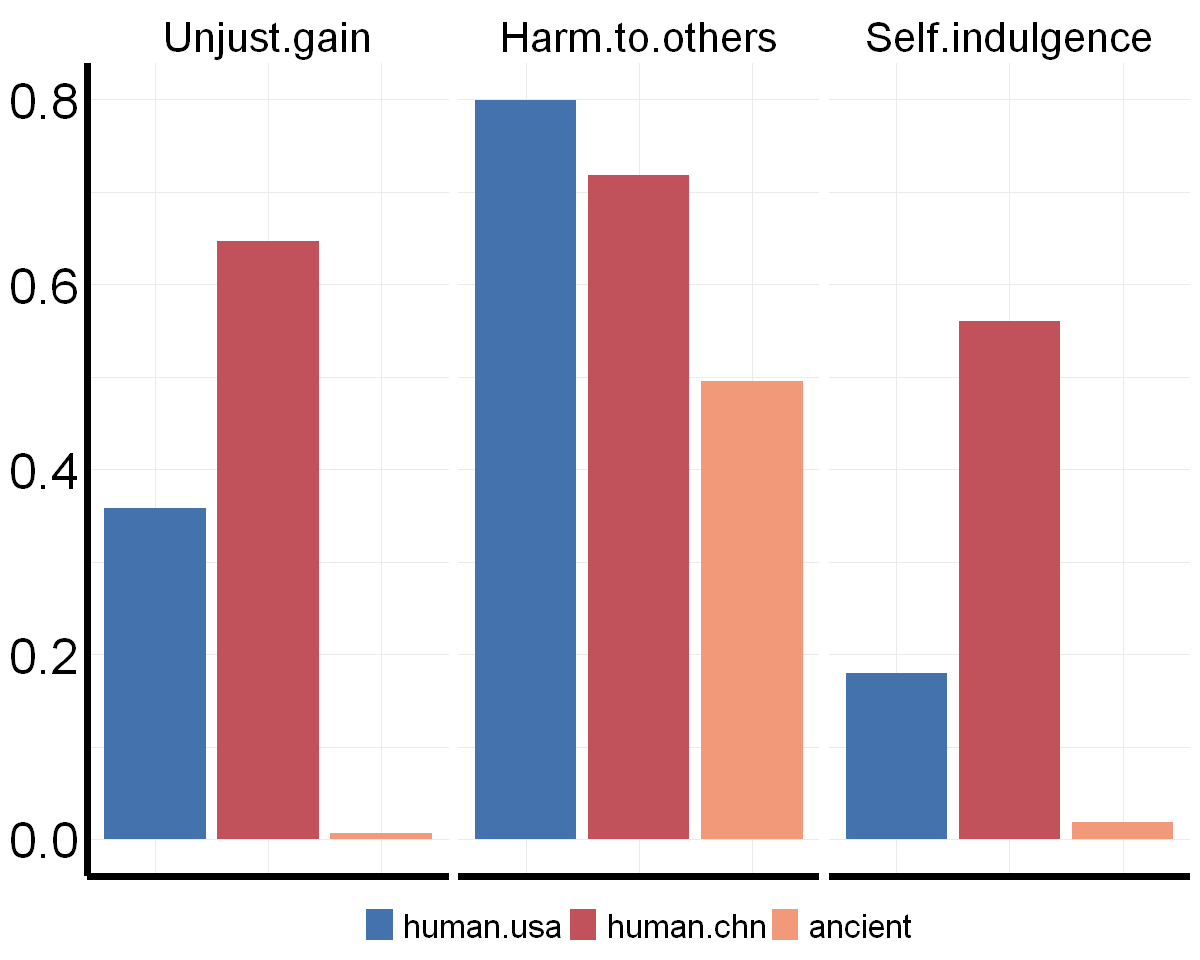

In [7]:
relative = FALSE
# 合并结果
partial_r <- rbind(data.frame(partial_r_usa),data.frame(partial_r_chn),data.frame(partial_r_chn_ancient))
rownames(partial_r) <- c('human.usa','human.chn','ancient')

# 计算比例
partial_r_prop <- partial_r
if (relative) {partial_r_prop = partial_r / rowSums(partial_r)}
partial_r_prop$'epoch' <- rownames(partial_r_prop)

# 转换数据
within_prop_across <- melt(partial_r_prop, id.vars = c('epoch'))
colnames(within_prop_across)[2] <- 'dim'
colnames(within_prop_across)[3] <- 'prop'

# 数据准备
within_prop_segment <- partial_r_prop[, -c(4)]
within_prop_segment <- data.frame(t(within_prop_segment))
within_prop_segment$'dim' <- rownames(within_prop_segment)
print(within_prop_segment)

# 转换为长格式
data_long <- within_prop_segment %>%
pivot_longer(cols = -dim, names_to = "variable", values_to = "value")

# 设置factor顺序
data_long$'variable' <- factor(data_long$'variable', levels = c('human.usa','human.chn','ancient'))
data_long$'dim' <- factor(data_long$'dim', levels = c('Unjust.gain', 'Harm.to.others', 'Self.indulgence'))

# 绘制图形
options(repr.plot.width = 10, repr.plot.height = 8)

ggplot(data_long, aes(x = variable, y = value, fill = variable)) +
geom_col() +
facet_wrap(~ dim, nrow = 1) + 
scale_color_manual(values = my.color) +
scale_fill_manual(values = my.color) +
theme_minimal() +
# ylim(0, ylim) +
theme(axis.title = element_blank(),
        axis.text.x = element_blank(),
        axis.text.y = element_text(size = 30, color = "black"),
        axis.line = element_line(linetype = 1, color = "black", size = 2),    
        legend.title = element_blank(),
        legend.text = element_text(size = 20),
        legend.position = 'bottom',
        strip.text = element_text(size = 25, color = "black"))

                human.usa human.chn    ancient             dim
Unjust.gain     0.2676822 0.3361765 0.01275449     Unjust.gain
Harm.to.others  0.5978752 0.3727168 0.95105297  Harm.to.others
Self.indulgence 0.1344427 0.2911067 0.03619255 Self.indulgence


Warning message:
"No shared levels found between `names(values)` of the manual scale and the
data's colour values."


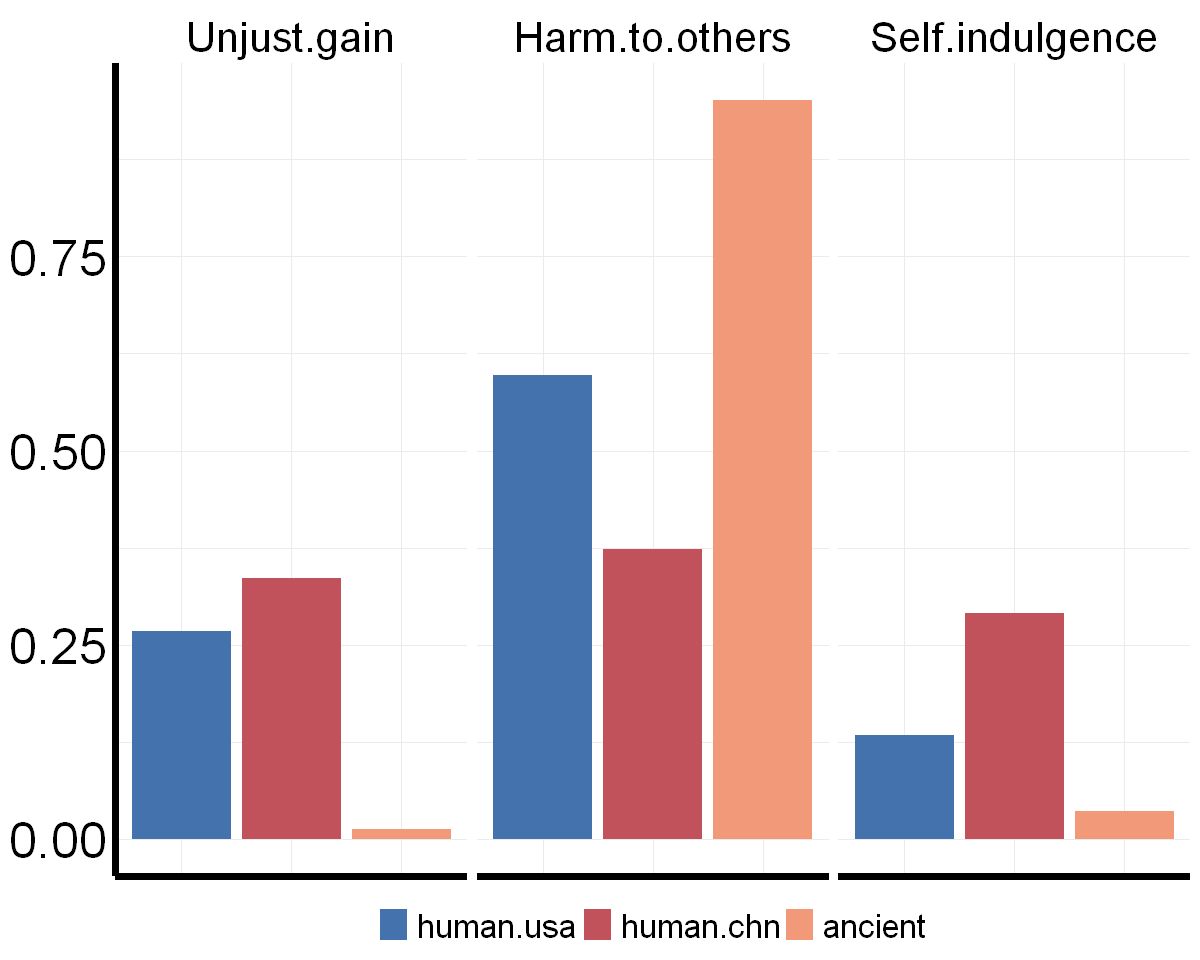

In [8]:
relative = TRUE
# 合并结果
partial_r <- rbind(data.frame(partial_r_usa),data.frame(partial_r_chn),data.frame(partial_r_chn_ancient))
rownames(partial_r) <- c('human.usa','human.chn','ancient')

# 计算比例
partial_r_prop <- partial_r
if (relative) {partial_r_prop = partial_r / rowSums(partial_r)}
partial_r_prop$'epoch' <- rownames(partial_r_prop)

# 转换数据
within_prop_across <- melt(partial_r_prop, id.vars = c('epoch'))
colnames(within_prop_across)[2] <- 'dim'
colnames(within_prop_across)[3] <- 'prop'

# 数据准备
within_prop_segment <- partial_r_prop[, -c(4)]
within_prop_segment <- data.frame(t(within_prop_segment))
within_prop_segment$'dim' <- rownames(within_prop_segment)
print(within_prop_segment)

# 转换为长格式
data_long <- within_prop_segment %>%
pivot_longer(cols = -dim, names_to = "variable", values_to = "value")

# 设置factor顺序
data_long$'variable' <- factor(data_long$'variable', levels = c('human.usa','human.chn','ancient'))
data_long$'dim' <- factor(data_long$'dim', levels = c('Unjust.gain', 'Harm.to.others', 'Self.indulgence'))

# 绘制图形
options(repr.plot.width = 10, repr.plot.height = 8)

ggplot(data_long, aes(x = variable, y = value, fill = variable)) +
geom_col() +
facet_wrap(~ dim, nrow = 1) + 
scale_color_manual(values = my.color) +
scale_fill_manual(values = my.color) +
theme_minimal() +
# ylim(0, ylim) +
theme(axis.title = element_blank(),
        axis.text.x = element_blank(),
        axis.text.y = element_text(size = 30, color = "black"),
        axis.line = element_line(linetype = 1, color = "black", size = 2),    
        legend.title = element_blank(),
        legend.text = element_text(size = 20),
        legend.position = 'bottom',
        strip.text = element_text(size = 25, color = "black"))

`summarise()` has grouped output by 'source'. You can override using the
`.groups` argument.


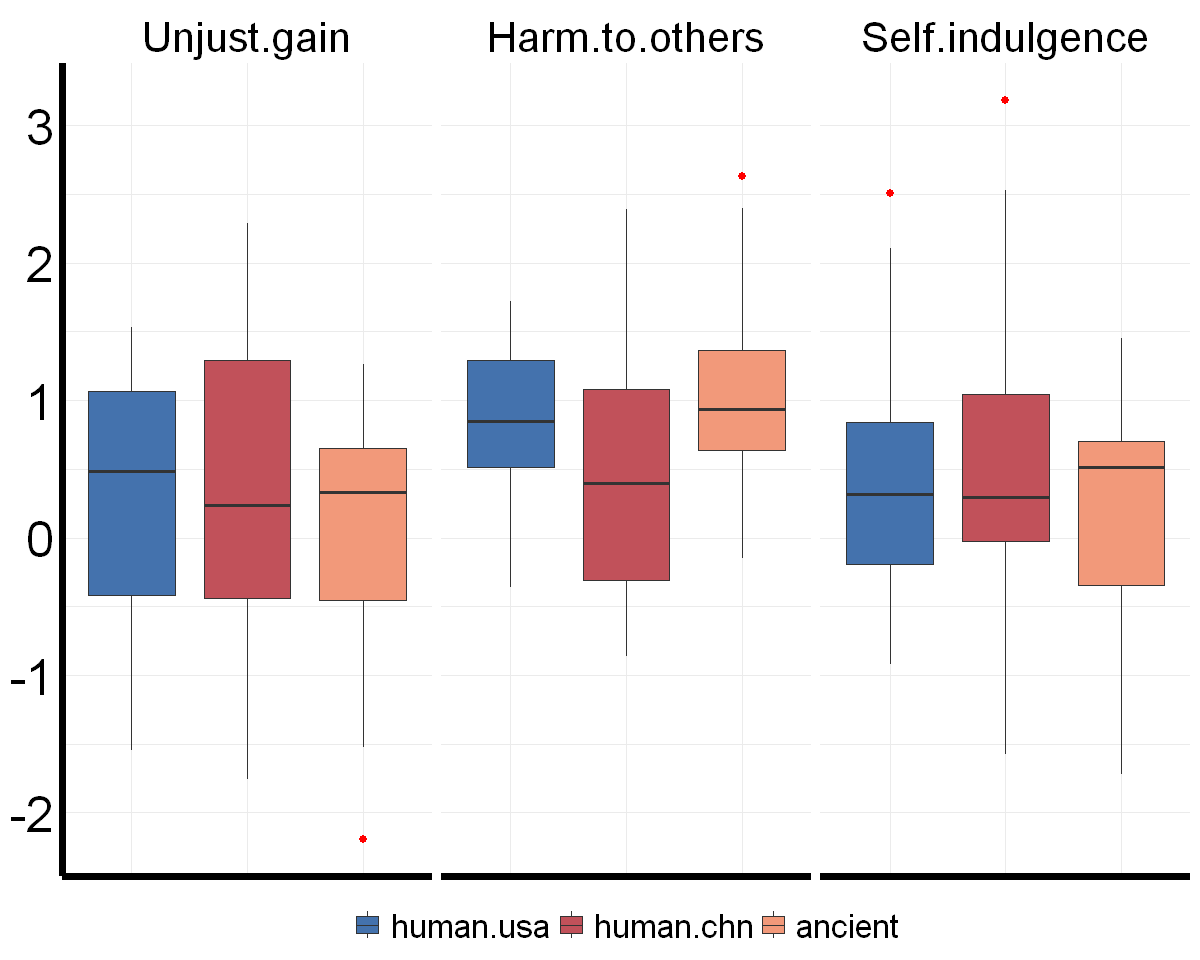

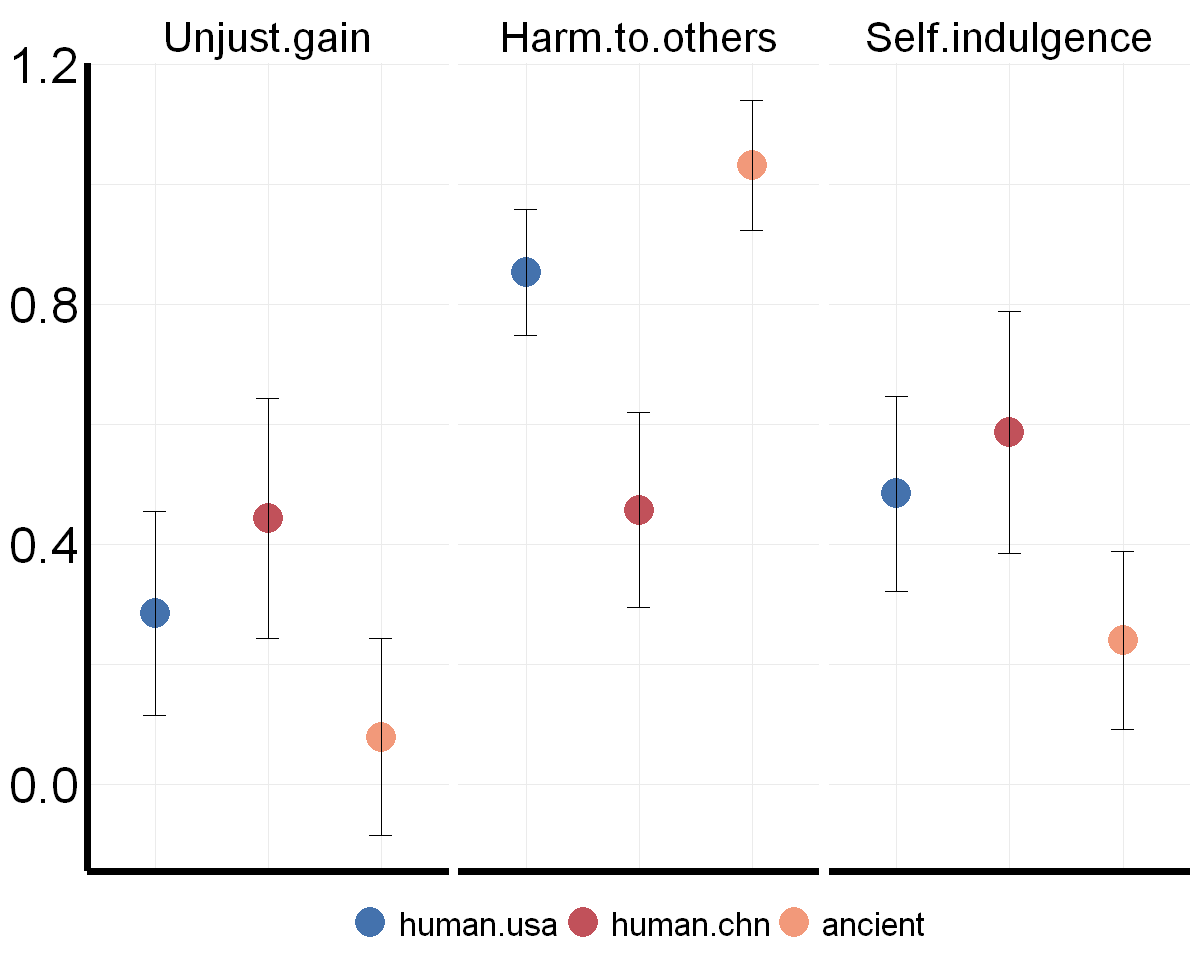

In [ ]:
num = 30
df_usa_top = df_usa %>% arrange(desc(Wrong)) %>% head(num) 
df_usa_top$'source' = 'human.usa'

df_chn_top = df_chn %>% arrange(desc(Wrong)) %>% head(num) 
df_chn_top$'source' = 'human.chn'

df_chn_ancient_top = df_chn_ancient %>% arrange(desc(Wrong)) %>% head(num) 
df_chn_ancient_top$'source' = 'ancient'

df_top = rbind(df_usa_top, df_chn_top, df_chn_ancient_top)
df_top = df_top %>% select(-c('Wrong'))
data_long = melt(df_top, id.vars = c('source'))
data_long$'source' <- factor(data_long$'source', levels = c('human.usa','human.chn', 'ancient'))
data_long$'variable' <- factor(data_long$'variable', levels = c('Unjust.gain','Harm.to.others','Self.indulgence'))

options(repr.plot.width = 10, repr.plot.height = 8)
ggplot(data_long, aes(x = source, y = value, fill = source)) +
  geom_boxplot(outlier.colour = "red", outlier.shape = 16, outlier.size = 2) +  # 使用箱线图
  facet_wrap(~ variable, nrow = 1) + 
  scale_fill_manual(values = my.color) +
  theme_minimal() +
  theme(axis.title = element_blank(),
        axis.text.x = element_blank(),
        axis.text.y = element_text(size = 30, color = "black"),
        axis.line = element_line(linetype = 1, color = "black", size = 2),    
        legend.title = element_blank(),
        legend.text = element_text(size = 20),
        legend.position = 'bottom',
        strip.text = element_text(size = 25, color = "black"))


# 计算每个组的均值和标准误
data_summary <- data_long %>%
  group_by(source, variable) %>%
  summarise(
    mean_value = mean(value, na.rm = TRUE),
    se_value = sd(value, na.rm = TRUE) / sqrt(n())  # 计算标准误
  )

options(repr.plot.width = 10, repr.plot.height = 8)

ggplot(data_summary, aes(x = source, y = mean_value, fill = source)) +
  geom_point(aes(color = source), size = 8, shape = 16) +  # 使用点表示均值
  geom_errorbar(aes(ymin = mean_value - se_value, ymax = mean_value + se_value), 
                width = 0.2, color = "black") +  # 添加标准误的误差条
  facet_wrap(~ variable, nrow = 1) + 
  scale_fill_manual(values = my.color) +
  scale_color_manual(values = my.color) +  # 设置点的颜色
  theme_minimal() +
  theme(axis.title = element_blank(),
        axis.text.x = element_blank(),
        axis.text.y = element_text(size = 30, color = "black"),
        axis.line = element_line(linetype = 1, color = "black", size = 2),    
        legend.title = element_blank(),
        legend.text = element_text(size = 20),
        legend.position = 'bottom',
        strip.text = element_text(size = 25, color = "black"))

In [ ]:
summary_result = summary(human_modern_usa_model)
summary_result
coefficients_usa <- summary_result$coefficients[seq(2,4),1]
coefficients_usa


Call:
lm(formula = Wrong ~ Unjust.gain + Harm.to.others + Self.indulgence, 
    data = df_usa)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.99749 -0.29590 -0.00741  0.35118  0.82162 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     1.189e-17  4.256e-02   0.000        1    
Unjust.gain     3.128e-01  4.277e-02   7.312 7.86e-11 ***
Harm.to.others  8.356e-01  4.277e-02  19.536  < 2e-16 ***
Self.indulgence 1.961e-01  4.277e-02   4.585 1.37e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4256 on 96 degrees of freedom
Multiple R-squared:  0.8261,	Adjusted R-squared:  0.8207 
F-statistic: 152.1 on 3 and 96 DF,  p-value: < 2.2e-16


Unjust.gain  Harm.to.others Self.indulgence 
      0.3127609       0.8355830       0.1961252

In [ ]:
summary_result = summary(human_modern_chn_model)
summary_result
coefficients_chn <- summary_result$coefficients[seq(2,4),1]
coefficients_chn


Call:
lm(formula = Wrong ~ Unjust.gain + Harm.to.others + Self.indulgence, 
    data = df_chn)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.06937 -0.24790 -0.02009  0.26394  1.08657 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     3.821e-16  3.958e-02    0.00        1    
Unjust.gain     5.279e-01  3.977e-02   13.27   <2e-16 ***
Harm.to.others  6.212e-01  3.977e-02   15.62   <2e-16 ***
Self.indulgence 4.401e-01  3.977e-02   11.06   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3958 on 96 degrees of freedom
Multiple R-squared:  0.8496,	Adjusted R-squared:  0.8449 
F-statistic: 180.8 on 3 and 96 DF,  p-value: < 2.2e-16


Unjust.gain  Harm.to.others Self.indulgence 
      0.5278799       0.6212136       0.4400703

In [ ]:
summary_result = summary(llm_ancient_chn_model)
summary_result
coefficients_ancient <- summary_result$coefficients[seq(2,4),1]
coefficients_ancient


Call:
lm(formula = Wrong ~ Unjust.gain + Harm.to.others + Self.indulgence, 
    data = df_chn_ancient)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.45647 -0.55384 -0.07523  0.44160  1.82333 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -3.235e-16  6.365e-02   0.000    1.000    
Unjust.gain      5.817e-02  6.390e-02   0.910    0.364    
Harm.to.others   7.045e-01  6.390e-02  11.025   <2e-16 ***
Self.indulgence  9.860e-02  6.390e-02   1.543    0.125    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.7202 on 124 degrees of freedom
Multiple R-squared:  0.5015,	Adjusted R-squared:  0.4895 
F-statistic: 41.58 on 3 and 124 DF,  p-value: < 2.2e-16


Unjust.gain  Harm.to.others Self.indulgence 
     0.05817149      0.70451305      0.09859876

Warning message:
"No shared levels found between `names(values)` of the manual scale and the
data's colour values."


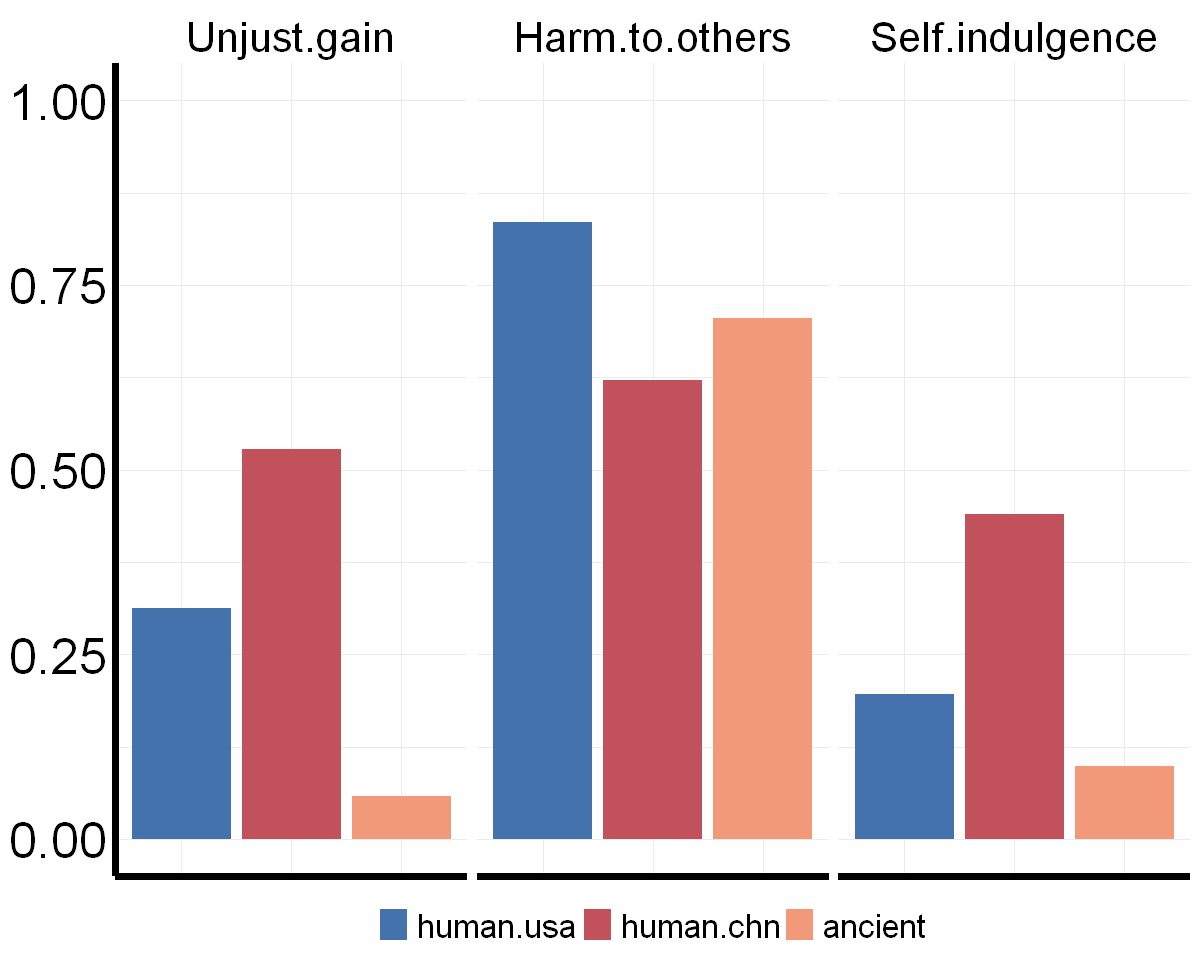

In [ ]:
coefficients_plot = cbind(coefficients_usa,coefficients_chn,coefficients_ancient) %>% data.frame()
colnames(coefficients_plot) = c('human.usa','human.chn','ancient')
coefficients_plot$'dim' <- rownames(coefficients_plot)
data_long <- coefficients_plot %>%
pivot_longer(cols = -dim, names_to = "variable", values_to = "value")
data_long$'variable' <- factor(data_long$'variable', levels = c('human.usa','human.chn','ancient'))
data_long$'dim' <- factor(data_long$'dim', levels =c('Unjust.gain','Harm.to.others','Self.indulgence'))

options(repr.plot.width = 10, repr.plot.height = 8)
ggplot(data_long, aes(x = variable, y = value, fill = variable)) +
geom_col() +
facet_wrap(~ dim, nrow = 1) + 
scale_color_manual(values = my.color) +
scale_fill_manual(values = my.color) +
theme_minimal() +
ylim(0, 1) +
theme(axis.title = element_blank(),
        axis.text.x = element_blank(),
        axis.text.y = element_text(size = 30, color = "black"),
        axis.line = element_line(linetype = 1, color = "black", size = 2),    
        legend.title = element_blank(),
        legend.text = element_text(size = 20),
        legend.position = 'bottom',
        strip.text = element_text(size = 25, color = "black"))

# Plot

Warning message:
"No shared levels found between `names(values)` of the manual scale and the
data's colour values."


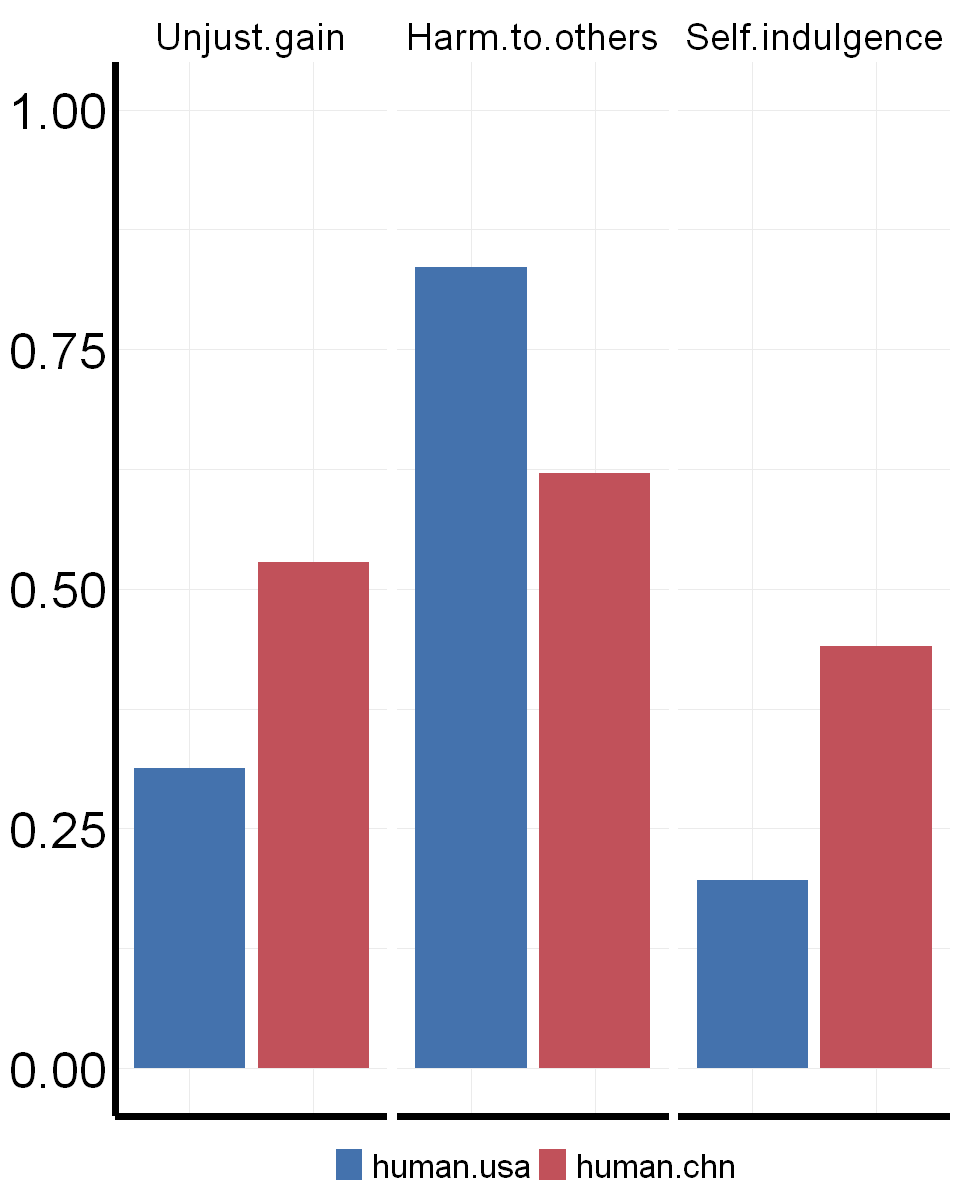

In [ ]:
coefficients_plot = cbind(coefficients_usa,coefficients_chn) %>% data.frame()
colnames(coefficients_plot) = c('human.usa','human.chn')
coefficients_plot$'dim' <- rownames(coefficients_plot)
data_long <- coefficients_plot %>%
pivot_longer(cols = -dim, names_to = "variable", values_to = "value")
data_long$'variable' <- factor(data_long$'variable', levels = c('human.usa','human.chn'))
data_long$'dim' <- factor(data_long$'dim', levels =c('Unjust.gain','Harm.to.others','Self.indulgence'))

options(repr.plot.width = 8, repr.plot.height = 10)
ggplot(data_long, aes(x = variable, y = value, fill = variable)) +
geom_col() +
facet_wrap(~ dim, nrow = 1) + 
scale_color_manual(values = my.color) +
scale_fill_manual(values = my.color) +
theme_minimal() +
ylim(0, 1) +
theme(axis.title = element_blank(),
        axis.text.x = element_blank(),
        axis.text.y = element_text(size = 30, color = "black"),
        axis.line = element_line(linetype = 1, color = "black", size = 2),    
        legend.title = element_blank(),
        legend.text = element_text(size = 20),
        legend.position = 'bottom',
        strip.text = element_text(size = 23, color = "black"))

`summarise()` has grouped output by 'source'. You can override using the
`.groups` argument.


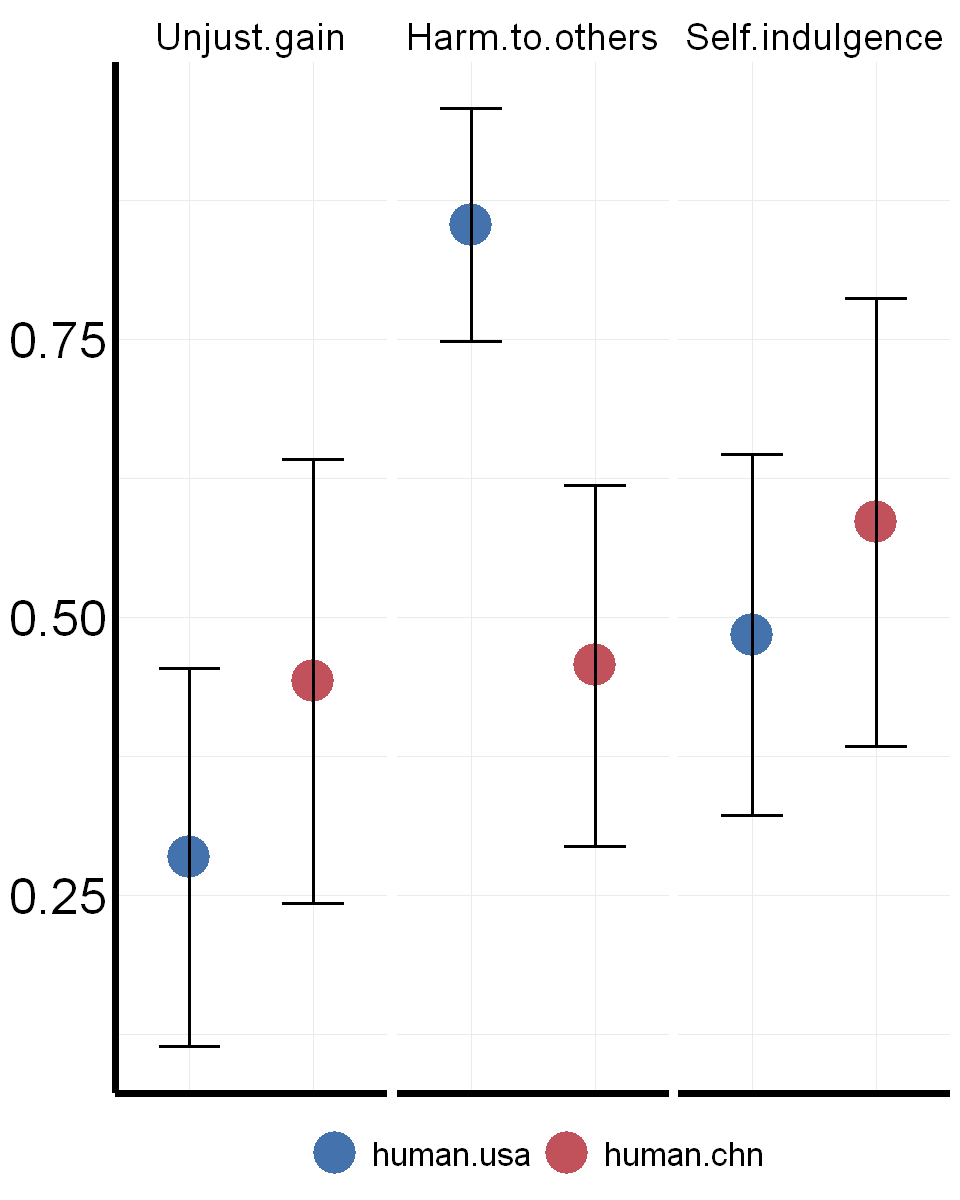

In [ ]:
num = 30
df_usa_top = df_usa %>% arrange(desc(Wrong)) %>% head(num) 
df_usa_top$'source' = 'human.usa'

df_chn_top = df_chn %>% arrange(desc(Wrong)) %>% head(num) 
df_chn_top$'source' = 'human.chn'

df_top = rbind(df_usa_top, df_chn_top)
df_top = df_top %>% select(-c('Wrong'))
data_long = melt(df_top, id.vars = c('source'))
data_long$'source' <- factor(data_long$'source', levels = c('human.usa','human.chn'))
data_long$'variable' <- factor(data_long$'variable', levels = c('Unjust.gain','Harm.to.others','Self.indulgence'))


data_summary <- data_long %>%
  group_by(source, variable) %>%
  summarise(
    mean_value = mean(value, na.rm = TRUE),
    se_value = sd(value, na.rm = TRUE) / sqrt(n())  # 计算标准误
  )


options(repr.plot.width = 8, repr.plot.height = 10)
ggplot(data_summary, aes(x = source, y = mean_value, fill = source)) +
  geom_point(aes(color = source), size = 12, shape = 16) +  # 使用点表示均值
  geom_errorbar(aes(ymin = mean_value - se_value, ymax = mean_value + se_value), 
                width = 0.5, color = "black",linewidth = 1) +  # 添加标准误的误差条
  facet_wrap(~ variable, nrow = 1) + 
  scale_fill_manual(values = my.color) +
  scale_color_manual(values = my.color) +  # 设置点的颜色
  theme_minimal() +
  theme(axis.title = element_blank(),
        axis.text.x = element_blank(),
        axis.text.y = element_text(size = 30, color = "black"),
        axis.line = element_line(linetype = 1, color = "black", size = 2),    
        legend.title = element_blank(),
        legend.text = element_text(size = 20),
        legend.position = 'bottom',
        strip.text = element_text(size = 23, color = "black"))

In [ ]:
library(rstatix)

compare_top_groups_Mtest <- function(df1, df2, num = 30) {
  # 提取前 num 行数据
  top_df1 <- df1 %>% arrange(desc(Wrong)) %>% head(num)
  top_df2 <- df2 %>% arrange(desc(Wrong)) %>% head(num)
  
  # 计算均值和标准误（可选）
  mean_df1 <- colMeans(top_df1[, 1:3])
  se_df1 <- apply(top_df1[, 1:3], 2, function(x) sd(x) / sqrt(length(x)))
  
  mean_df2 <- colMeans(top_df2[, 1:3])
  se_df2 <- apply(top_df2[, 1:3], 2, function(x) sd(x) / sqrt(length(x)))
  
  # 合并均值和标准误
  summary_df1 <- rbind(mean = mean_df1, se = se_df1)
  summary_df2 <- rbind(mean = mean_df2, se = se_df2)
  
  # 执行 Mann-Whitney U 检验（Wilcoxon 秩和检验）并计算效应量
  mw_test_results <- list()
  
  for (col in colnames(top_df1)[1:3]) {
    # 合并两组数据（用于 rstatix）
    combined_data <- data.frame(
      value = c(top_df1[[col]], top_df2[[col]]),
      group = rep(c("Group1", "Group2"), times = c(nrow(top_df1), nrow(top_df2)))
    )
    
    # 执行 Wilcoxon 检验
    wilcox_test_result <- combined_data %>%
      wilcox_test(value ~ group, exact = FALSE) %>%
      add_significance()
    
    # 计算效应量（r）
    effect_size <- combined_data %>%
      wilcox_effsize(value ~ group)
    
    # 存储结果
    mw_test_results[[col]] <- list(
      test_type = "Mann-Whitney U test (via rstatix)",
      statistic = wilcox_test_result$statistic,
      p_value = wilcox_test_result$p,
      p_signif = wilcox_test_result$p.signif,
      effect_size = effect_size$effsize,
      effect_magnitude = effect_size$magnitude
    )
  }
  
  # 返回结果
  return(list(
    summary_df1 = summary_df1,
    summary_df2 = summary_df2,
    mw_test_results = mw_test_results
  ))
}

# 示例调用
result <- compare_top_groups_Mtest(df_chn, df_usa, 30)

print("Mann-Whitney U 检验结果（含效应量）：")
print(result$mw_test_results)

Registered S3 method overwritten by 'coin':
  method   from 
  print.ci asbio



[1] "Mann-Whitney U 检验结果（含效应量）："
$Unjust.gain
$Unjust.gain$test_type
[1] "Mann-Whitney U test (via rstatix)"

$Unjust.gain$statistic
  W 
488 

$Unjust.gain$p_value
[1] 0.579

$Unjust.gain$p_signif
[1] "ns"

$Unjust.gain$effect_size
Effect size (r) 
     0.07252912 

$Unjust.gain$effect_magnitude
[1] small
Levels: small < moderate < large


$Harm.to.others
$Harm.to.others$test_type
[1] "Mann-Whitney U test (via rstatix)"

$Harm.to.others$statistic
  W 
320 

$Harm.to.others$p_value
[1] 0.0555

$Harm.to.others$p_signif
[1] "ns"

$Harm.to.others$effect_size
Effect size (r) 
      0.2481259 

$Harm.to.others$effect_magnitude
[1] small
Levels: small < moderate < large


$Self.indulgence
$Self.indulgence$test_type
[1] "Mann-Whitney U test (via rstatix)"

$Self.indulgence$statistic
  W 
480 

$Self.indulgence$p_value
[1] 0.663

$Self.indulgence$p_signif
[1] "ns"

$Self.indulgence$effect_size
Effect size (r) 
     0.05725983 

$Self.indulgence$effect_magnitude
[1] small
Levels: small < modera

In [ ]:
evil_action = read.xlsx('现代中国人数据最终版/Morality_feature_beh_0427.xlsx',sheet = 'Evil_actions')
evil_action_map = setNames(evil_action$'English_simp', evil_action$'Chinese_modified')
df_chn_plot = df_chn
df_chn_plot = df_chn_plot %>%
`rownames<-`(evil_action_map[rownames(.)])
df_chn_plot = df_chn_plot %>% arrange(desc(Wrong)) %>% head(30)
df_chn_plot$'type' = 'chn'

df_usa_plot = df_usa
df_usa_plot = df_usa_plot %>%
`rownames<-`(evil_action_map[rownames(.)])
df_usa_plot = df_usa_plot %>% arrange(desc(Wrong)) %>% head(30)
df_usa_plot$'type' = 'usa'

df_plot = rbind(as.matrix(df_chn_plot),as.matrix(df_usa_plot))
write.csv(df_plot,'validity/evil_top30.csv')

# WordCloud

In [ ]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import numpy as np
import pandas as pd

#import seaborn as sns
import matplotlib.pyplot as plt

# 词云图的背景
mask = np.array(Image.open('validity/mask.png'))

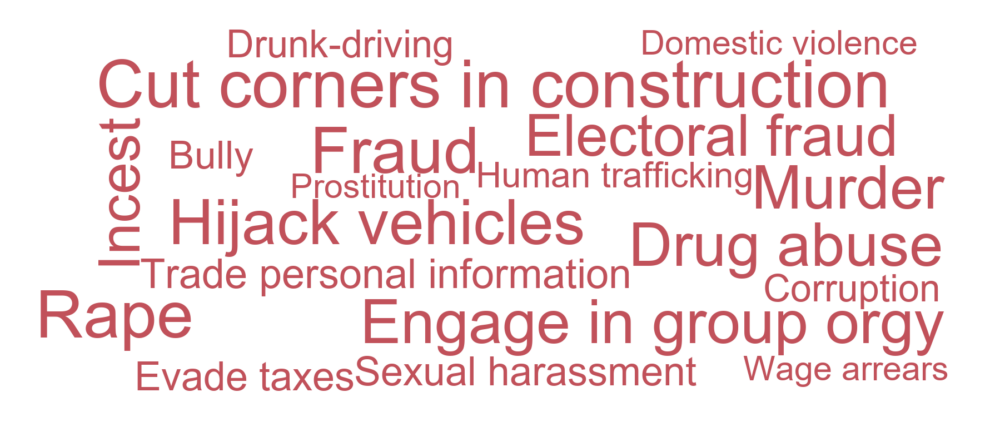

In [ ]:
df = pd.read_csv('validity//evil_top30.csv',index_col=0)
df_chn = df.loc[df.type == 'chn']
df_dict = {k:v for k,v in zip(df_chn.index, df_chn['Wrong'])}

wc = WordCloud(background_color = 'white',mask=mask,
               font_path=r"C:\Windows\Fonts\Arial.ttf",max_font_size=120,min_font_size=50,
               mode='RGBA',color_func=lambda *args, **kwargs: "#C1515A").\
               generate_from_frequencies(df_dict)

plt.figure(figsize=(4,4),dpi=300)
plt.imshow(wc,interpolation="bilinear")  
plt.axis("off")  
plt.show()

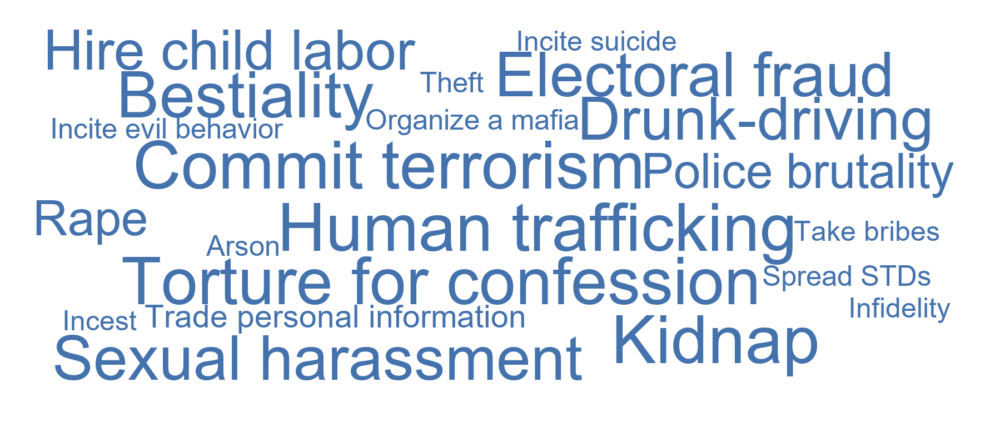

In [ ]:
df = pd.read_csv('validity//evil_top30.csv',index_col=0)
df_usa = df.loc[df.type == 'usa']
df_dict = {k:v for k,v in zip(df_usa.index, df_usa['Wrong'])}

wc = WordCloud(background_color = 'white',mask=mask,
               font_path=r"C:\Windows\Fonts\Arial.ttf",max_font_size=120,min_font_size=50,
               mode='RGBA',color_func=lambda *args, **kwargs: "#4472AD").\
               generate_from_frequencies(df_dict)

plt.figure(figsize=(4,4),dpi=300)
plt.imshow(wc,interpolation="bilinear")  
plt.axis("off")  
plt.show()